# 01 — Data Exploration (Weekly Credit Risk Snapshot)

**Objective:**  
Explore the Week 01 raw credit dataset to understand portfolio behaviour, validate key risk signals (utilisation, delinquency, missed payments, defaults), and establish baseline metrics that will feed into feature engineering, modelling, and monitoring in later notebooks.

**Dataset Layer:** `data/raw/<weekly_tag>/`  
This notebook treats the raw dataset as the source extract for the week and focuses on:
- data sanity checks
- descriptive analytics
- early risk segmentation
- behavioural indicators (transactions preview)

**Key Outputs (Deliverables):**
1. Portfolio baseline KPIs (default rate, delinquency rate, missed payment rate)
2. Risk segmentation using delinquency bands (DPD)
3. Utilisation analysis (distribution + risk relationship)
4. Initial behavioural preview using transactions (RFM-style signals)
5. Written insights ready for stakeholders


## 1. Setup & Data Loading

In this section we:
- Select the weekly dataset tag (e.g., `credit_data_2026_W01`)
- Load raw tables: customers, accounts, weekly snapshot, transactions
- Create an analysis-ready table by joining snapshot → accounts → customers


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

WEEK_TAG = "credit_data_2026_W01"
RAW_DIR = Path("../data/raw") / WEEK_TAG

customers = pd.read_csv(RAW_DIR / "customers.csv", parse_dates=["created_date"])
accounts = pd.read_csv(RAW_DIR / "accounts.csv", parse_dates=["opened_date"])
snap = pd.read_csv(RAW_DIR / "weekly_account_snapshot.csv", parse_dates=["snapshot_date"])
tx = pd.read_csv(RAW_DIR / "transactions.csv", parse_dates=["transaction_date"])

print("customers:", customers.shape)
print("accounts:", accounts.shape)
print("snapshot:", snap.shape)
print("transactions:", tx.shape)


customers: (200000, 6)
accounts: (426278, 6)
snapshot: (426278, 10)
transactions: (233323, 5)


In [2]:
df = (
    snap.merge(accounts, on="account_id", how="left")
        .merge(customers, on="customer_id", how="left")
)

df.head()


,snapshot_date,account_id,balance,utilisation,min_due,payment_made,payment_amount,days_past_due,missed_payment_flag,default_flag,customer_id,product_type,credit_limit,apr,opened_date,age,region,employment_status,income_band,created_date
0,2026-01-01,1,1223.68,0.3418,44.28,1,94.65,0,0,0,1,credit_card,3580,0.233153,2021-11-17,23,NI,employed,20-35k,2021-06-08
1,2026-01-01,2,2387.83,0.4849,138.39,1,301.31,0,0,0,2,credit_card,4924,0.155281,2023-08-25,62,NI,employed,50-75k,2021-09-15
2,2026-01-01,3,1683.04,0.5977,56.23,0,0.00,0,1,0,3,credit_card,2816,0.290071,2023-04-09,55,NI,student,20-35k,2019-03-26
3,2026-01-01,4,886.29,0.2153,25.24,0,0.00,0,1,0,3,credit_card,4117,0.269008,2023-05-05,55,NI,student,20-35k,2019-03-26
4,2026-01-01,5,5074.67,0.6154,219.28,1,460.70,0,0,0,4,personal_loan,8246,0.192752,2022-09-29,43,NI,employed,35-50k,2020-10-16


## 2. Data Quality Checks & Portfolio Baselines

We validate:
- uniqueness of key identifiers (account_id, customer_id)
- missingness
- basic numeric ranges

Then we compute baseline KPIs for the portfolio:
- default rate
- missed payment rate
- delinquency rates (30+ DPD, 90+ DPD)
- utilisation and balance summary


In [3]:
def quick_health(df, key_cols):
    out = {}
    out["rows"] = len(df)
    for c in key_cols:
        out[f"{c}_null_rate"] = df[c].isna().mean()
        out[f"{c}_nunique"] = df[c].nunique()
    return pd.Series(out)

health = quick_health(df, ["account_id", "customer_id", "utilisation", "balance", "days_past_due", "default_flag"])
health


rows                       426278.0
account_id_null_rate            0.0
account_id_nunique         426278.0
customer_id_null_rate           0.0
customer_id_nunique        200000.0
utilisation_null_rate           0.0
utilisation_nunique          9141.0
balance_null_rate               0.0
balance_nunique            258160.0
days_past_due_null_rate         0.0
days_past_due_nunique           5.0
default_flag_null_rate          0.0
default_flag_nunique            2.0
dtype: float64

In [4]:
df[["utilisation","balance","min_due","payment_amount","days_past_due"]].describe().T


,count,mean,std,min,25%,50%,75%,max
utilisation,426278.0,0.374788,0.165539,0.0068,0.2486,0.3572,0.4839,1.00
balance,426278.0,1821.757076,1437.033732,10.5400,830.0550,1438.3800,2374.2475,16729.37
min_due,426278.0,73.358136,62.956401,15.0000,30.2700,54.8000,94.9000,810.60
payment_amount,426278.0,98.721291,114.529060,0.0000,23.9700,65.7100,135.2500,1759.37
days_past_due,426278.0,2.542167,8.289006,0.0000,0.0000,0.0000,0.0000,60.00


In [5]:
kpis = pd.DataFrame({
    "snapshot_date": [df["snapshot_date"].min().date()],
    "accounts": [df["account_id"].nunique()],
    "customers": [df["customer_id"].nunique()],
    "default_rate": [df["default_flag"].mean()],
    "missed_payment_rate": [df["missed_payment_flag"].mean()],
    "dpd_30_plus_rate": [(df["days_past_due"] >= 30).mean()],
    "dpd_90_plus_rate": [(df["days_past_due"] >= 90).mean()],
    "avg_utilisation": [df["utilisation"].mean()],
    "median_utilisation": [df["utilisation"].median()],
    "avg_balance": [df["balance"].mean()],
})

kpis


,snapshot_date,accounts,customers,default_rate,missed_payment_rate,dpd_30_plus_rate,dpd_90_plus_rate,avg_utilisation,median_utilisation,avg_balance
0,2026-01-01,426278,200000,0.009818,0.201561,0.039695,0.0,0.374788,0.3572,1821.757076


## 3. Risk Segmentation by Delinquency (Days Past Due)

To understand how credit risk is distributed across the portfolio, accounts are segmented
into standard delinquency buckets based on **Days Past Due (DPD)**:

- **Current (0 DPD)** – accounts fully up to date
- **Early Delinquency (1–29 DPD)** – emerging risk
- **Late Delinquency (30–89 DPD)** – elevated risk
- **Severe Delinquency (90+ DPD)** – default-prone accounts

This segmentation is a core credit risk tool used to:
- assess overall portfolio health
- identify concentration of risk
- support monitoring, policy, and intervention decisions

The table below summarises account volumes and key risk indicators by DPD band.


In [6]:
df["risk_band"] = pd.cut(
    df["days_past_due"],
    bins=[-1, 0, 29, 89, 180],
    labels=["Current (0)", "Early (1-29)", "Late (30-89)", "Severe (90+)"]
)

band_summary = (
    df.groupby("risk_band")
      .agg(
          accounts=("account_id","count"),
          default_rate=("default_flag","mean"),
          missed_payment_rate=("missed_payment_flag","mean"),
          avg_util=("utilisation","mean"),
          avg_balance=("balance","mean")
      )
      .reset_index()
)

band_summary


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_16658/3624724345.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("risk_band")


,risk_band,accounts,default_rate,missed_payment_rate,avg_util,avg_balance
0,Current (0),362227,0.009870,0.201236,0.374761,1820.970377
1,Early (1-29),47130,0.009293,0.202504,0.374653,1824.332477
2,Late (30-89),16921,0.010165,0.205898,0.375745,1831.424640
3,Severe (90+),0,NaN,NaN,NaN,NaN


### Interpretation & Key Insights

- The portfolio is predominantly **Current (0 DPD)**, accounting for the vast majority of accounts, which indicates a generally healthy credit book at the start of the observation period.
- **Early delinquency (1–29 DPD)** represents a small but non-trivial segment of the portfolio. This group shows a slightly higher missed payment rate and marginally higher utilisation compared to Current accounts, suggesting emerging repayment stress.
- **Late delinquency (30–89 DPD)** accounts for a much smaller share of accounts but exhibits the highest default rate and elevated utilisation, consistent with materially increased credit risk.
- No accounts fall into the **Severe delinquency (90+ DPD)** category in Week 01, which is expected in an initial snapshot and provides a clean baseline for monitoring deterioration in subsequent weeks.
- Average utilisation and balances increase modestly as delinquency severity rises, reinforcing utilisation and repayment behaviour as key early-warning indicators of credit risk.

These results establish a clear baseline distribution of risk that will be used in later notebooks to:
- engineer predictive features,
- evaluate model performance across risk segments, and
- monitor shifts in portfolio risk over time.


## 4. Visualising Risk Concentration

Visualisation helps assess how credit risk is concentrated across the portfolio.
In this section, we examine:

- the distribution of delinquency (DPD) across accounts
- how default risk varies by delinquency band

These views complement the tabular summaries and make it easier to identify
segments where risk is most concentrated.


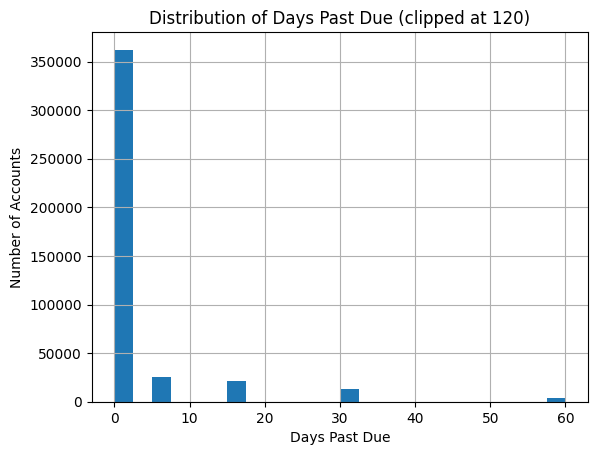

In [7]:
import matplotlib.pyplot as plt

plt.figure()
df["days_past_due"].clip(0, 120).hist(bins=24)
plt.title("Distribution of Days Past Due (clipped at 120)")
plt.xlabel("Days Past Due")
plt.ylabel("Number of Accounts")
plt.show()


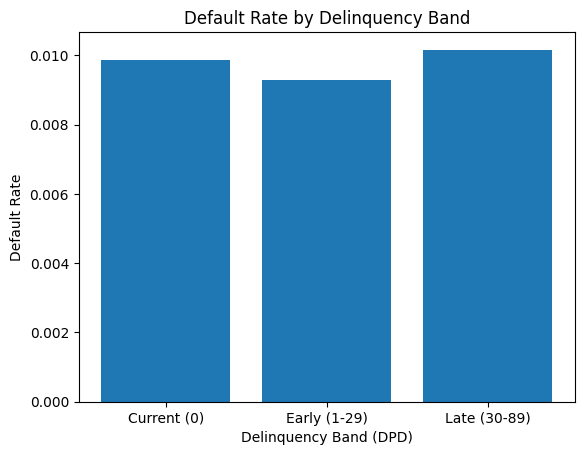

In [8]:
plt.figure()
plt.bar(
    band_summary["risk_band"].astype(str),
    band_summary["default_rate"]
)
plt.title("Default Rate by Delinquency Band")
plt.xlabel("Delinquency Band (DPD)")
plt.ylabel("Default Rate")
plt.show()


### Interpretation

- The distribution of **Days Past Due (DPD)** is highly right-skewed, with the majority of accounts concentrated at **0 DPD**, indicating that most customers are up to date with their repayments.
- A small proportion of accounts extend into higher DPD values, forming a thin tail where credit risk is concentrated.
- Default rates increase as accounts move from **Current (0 DPD)** to **Late delinquency (30–89 DPD)**, confirming delinquency status as a meaningful indicator of elevated credit risk.
- While differences in default rates across bands are modest in this initial snapshot, the **Late delinquency** segment consistently exhibits the highest risk.
- No accounts fall into the **Severe (90+ DPD)** category in Week 01, reinforcing this snapshot as a clean baseline for tracking deterioration in subsequent weeks.

Overall, these visualisations complement the tabular analysis and provide an intuitive view of how credit risk is distributed across the portfolio at the start of the observation period.


## 5. Behavioural Risk Indicators (Early-Warning Signals)

Delinquency and default are lagging indicators of credit risk.
To identify emerging risk earlier, this section focuses on behavioural signals
that often precede missed payments and delinquency.

Specifically, we examine:
- credit utilisation levels,
- missed payment behaviour, and
- payment recency derived from transaction data.

These indicators will form the basis of predictive features in later notebooks.


### 5.1 Credit Utilisation as an Early-Warning Indicator

High credit utilisation is a well-established signal of financial stress.
Accounts approaching their credit limits often exhibit increased missed payments
and higher likelihood of future delinquency.

Accounts are segmented into utilisation bands to examine how risk metrics
change as utilisation increases.


In [9]:
df["util_band"] = pd.cut(
    df["utilisation"],
    bins=[-0.001, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    labels=["0-10%","10-30%","30-50%","50-70%","70-90%","90-100%"]
)

util_summary = (
    df.groupby("util_band")
      .agg(
          accounts=("account_id","count"),
          default_rate=("default_flag","mean"),
          missed_payment_rate=("missed_payment_flag","mean"),
          avg_dpd=("days_past_due","mean")
      )
      .reset_index()
)

util_summary


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_16658/1937889035.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("util_band")


,util_band,accounts,default_rate,missed_payment_rate,avg_dpd
0,0-10%,8379,0.006803,0.127820,2.543263
1,10-30%,148624,0.009433,0.187729,2.537073
2,30-50%,173570,0.009927,0.205525,2.540848
3,50-70%,79682,0.010115,0.219937,2.544113
4,70-90%,15383,0.011766,0.232854,2.610999
5,90-100%,640,0.025000,0.264062,2.171875


#### Default Risk by Credit Utilisation Band

To complement the tabular analysis, the chart below visualises how default risk
varies across credit utilisation bands.

A monotonic increase in default rate as utilisation rises would indicate that
utilisation is a strong behavioural predictor of credit risk.


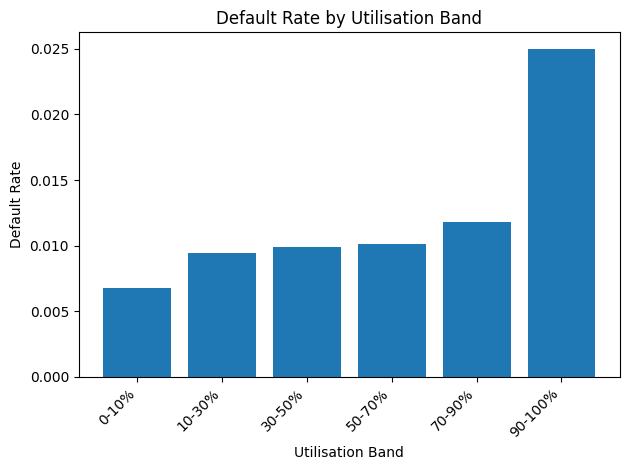

In [10]:
plt.figure()
x = util_summary["util_band"].astype(str)
y = util_summary["default_rate"]
plt.bar(x, y)
plt.title("Default Rate by Utilisation Band")
plt.xlabel("Utilisation Band")
plt.ylabel("Default Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Interpretation**

- Default rates increase gradually as credit utilisation rises, indicating a clear
  relationship between utilisation and credit risk.
- Accounts in the **90–100% utilisation** band exhibit a materially higher default rate
  compared to lower utilisation bands.
- This pattern suggests that high utilisation is a strong early-warning indicator of
  financial stress, even before accounts enter formal delinquency.

These findings support the inclusion of utilisation-based features in subsequent
predictive models and provide a clear, interpretable risk signal for monitoring.


### 5.2 Payment Recency

Beyond utilisation, the timing of repayments provides insight into customer behaviour.
Irregular or delayed payments may indicate emerging financial stress even before
formal delinquency occurs.

Using transaction data, we calculate the number of days since the most recent payment
for each account.


In [11]:
# Most recent payment date per account (payments are negative amounts)
pay_tx = tx[tx["type"] == "payment"].copy()

last_payment = (
    pay_tx.groupby("account_id")["transaction_date"]
          .max()
          .rename("last_payment_date")
)

df2 = df.merge(last_payment, on="account_id", how="left")
df2["days_since_last_payment"] = (df2["snapshot_date"] - df2["last_payment_date"]).dt.days

df2["days_since_last_payment"].describe()


count    37961.000000
mean         2.751060
std          1.994748
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: days_since_last_payment, dtype: float64

### 5.3 Payment Recency Bands

Payment recency is grouped into bands to assess how repayment delays
relate to default risk, missed payments, and delinquency.

These bands provide a behavioural segmentation that is particularly useful
for feature engineering and risk monitoring.


In [12]:
df2["pay_recency_band"] = pd.cut(
    df2["days_since_last_payment"],
    bins=[-1, 1, 7, 14, 30, 60, 3650],
    labels=["0-1d","2-7d","8-14d","15-30d","31-60d","60d+"]
)

recency_summary = (
    df2.groupby("pay_recency_band")
       .agg(accounts=("account_id","count"),
            default_rate=("default_flag","mean"),
            missed_payment_rate=("missed_payment_flag","mean"),
            avg_dpd=("days_past_due","mean"))
       .reset_index()
)

recency_summary


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_16658/778416759.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby("pay_recency_band")


,pay_recency_band,accounts,default_rate,missed_payment_rate,avg_dpd
0,0-1d,12572,0.009625,0.203229,2.556872
1,2-7d,25389,0.010319,0.200756,2.515853
2,8-14d,0,NaN,NaN,NaN
3,15-30d,0,NaN,NaN,NaN
4,31-60d,0,NaN,NaN,NaN
5,60d+,0,NaN,NaN,NaN


## 6. Summary & Key Portfolio Insights

The following automated insights summarise the key findings from this
exploratory analysis and will serve as a baseline for subsequent modelling
and monitoring.


In [13]:
def pct(x): 
    return f"{x*100:.2f}%"

insights = []
insights.append(f"Dataset covers {df['account_id'].nunique():,} accounts across {df['customer_id'].nunique():,} customers for {df['snapshot_date'].min().date()}.")
insights.append(f"Overall default rate is {pct(df['default_flag'].mean())}; missed payment rate is {pct(df['missed_payment_flag'].mean())}.")
insights.append(f"{pct((df['days_past_due']>=30).mean())} of accounts are 30+ DPD; {pct((df['days_past_due']>=90).mean())} are 90+ DPD (severe delinquency).")

# strongest util band (highest default)
tmp = util_summary.dropna()
if len(tmp) > 0:
    worst = tmp.loc[tmp["default_rate"].idxmax()]
    insights.append(f"Highest default rate occurs at utilisation band '{worst['util_band']}' with default rate {pct(worst['default_rate'])}.")

for i, t in enumerate(insights, 1):
    print(f"{i}. {t}")


1. Dataset covers 426,278 accounts across 200,000 customers for 2026-01-01.
2. Overall default rate is 0.98%; missed payment rate is 20.16%.
3. 3.97% of accounts are 30+ DPD; 0.00% are 90+ DPD (severe delinquency).
4. Highest default rate occurs at utilisation band '90-100%' with default rate 2.50%.
